# 8. PCA

In [7]:
from fixedincome2025 import table

## Overview

* So far we have covered
    * (Treasury) yield curve construction: A snap shot of the market
    * Duration and convexity: What happens to the portfolio value if the curve moves parallelly
    * Delta ladder: What happens to the portfolio value if the curve moves but not parallelly
* Something is missing: How will tomorrow's curve move?
    * Of course no one knows exactly, but we can still say something
* Principal component analysis (PCA) provides a great tool to model yield curve movements and to hedge any portfolios that have rates exposure

## Modeling Yield Curve Movements

* Although the below curve has 14 points, when we model this curve's movement, we should not model it by 14 independent random variables

In [6]:
table('yc_10092025').T

,1m,1.5m,2m,3m,4m,6m,1y,2y,3y,5y,7y,10y,20y,30y
Yield,4.2%,4.17%,4.11%,4.03%,3.95%,3.83%,3.66%,3.6%,3.59%,3.74%,3.92%,4.14%,4.7%,4.72%


* Rates for nearby maturities on the curve tend to move together—both in direction and magnitude—because the corresponding bonds are close substitutes.
    * If 2y bond is too expensive, investors with the need can just buy 3y bond
    * If borrowing for 2y is too expensive, borrowers can just borrow for 3y
* As we will see now, PCA tells us 3 independent random variables are enough
* First we need some math

## Singular Value Decomposition (SVD)

* Every $m\times n$ matrix $X$ can be written as
$$
X = USV^{\mathsf T}, 
$$
where
    * $U$ is an $m\times m$ unitary matrix (more on unitary matrices later)
    * $V$ is an $n\times n$ unitary matrix
    * $S$ is an $m\times n$ matrix with nonzero entries only on the main diagonal, meaning if $S=(s_{i,j})$, then $s_{i,j} \neq 0$ only when $i = j$. Also the nonzero elements are sorted, meaning $s_{1, 1} \geq s_{2, 2} \geq s_{3, 3} \geq \cdots \geq s_{n, n}$
* For our purpose which is to model the curve movement, the important case is $m>n$

## The $S$ Matrix

$$
S = \begin{pmatrix}
s_{1, 1} & 0 & \cdots & 0\\ 
0 & s_{2, 2} & \cdots & 0\\ 
\vdots & \vdots & \ddots & \vdots\\ 
0 & 0 & \cdots & s_{n, n}\\ 
\vdots & \vdots & \vdots & \vdots\\ 
0 & 0 & \cdots & 0\\ 
\end{pmatrix}_{m\times n}
$$
* $s_{1, 1} \geq s_{2, 2} \geq s_{3, 3} \geq \cdots \geq s_{n, n}$

## Unitary Matrix

* Recall that $X_{m\times n} = USV^{\mathsf T}$, where $U_{m\times m}$ and $V_{n\times n}$ are both unitary
* Definition: A matrix $V_{n\times n}$ is said to be unitary if $V^{\mathsf T}V = I_n$, the $n\times n$ identity matrix
* Easy to compute inverse: $V^{-1} = V^{\mathsf T}$ by definition
* Let
$$
V = \begin{pmatrix}
|&|&  & | \\
v_1 & v_2 & \cdots & v_n \\
|&|&  & | \\
\end{pmatrix}, 
$$
where $v_j$ are column vectors

## Unitary Matrix (Cont.)

* $V^{\mathsf T}V = I_n$: 
\begin{align*}
V^{\mathsf T}V &= \begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{} \\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{} \\
& \vdots & \\
\frac{\qquad}{} & v_n^{\mathsf T} & \frac{\qquad}{} \\
\end{pmatrix}
\begin{pmatrix}
|&|&  & | \\
v_1 & v_2 & \cdots & v_n \\
|&|&  & | \\
\end{pmatrix}\\
&= \begin{pmatrix}
\langle v_1, v_1\rangle & \langle v_1, v_2\rangle & \cdots & \langle v_1, v_n\rangle\\
\langle v_2, v_1\rangle & \langle v_2, v_2\rangle & \cdots & \langle v_2, v_n\rangle\\
\vdots&\vdots&\ddots&\vdots \\
\langle v_n, v_1\rangle & \langle v_n, v_2\rangle & \cdots & \langle v_n, v_n\rangle
\end{pmatrix} = \begin{pmatrix}
1 & 0 & \cdots & 0\\
0 & 1 & \cdots & 0\\
\vdots&\vdots&\ddots&\vdots \\
0 & 0 & \cdots & 1
\end{pmatrix}, 
\end{align*}
where $\langle \cdot, \cdot\rangle$ stands for the inner product of two vectors
* Definition: If $\vec a = (a_1, a_2, \ldots, a_n)^{\mathsf T}$ and $\vec b = (b_1, b_2, \ldots, b_n)^{\mathsf T}$, then $\langle \vec a, \vec b\rangle = a_1b_1 + a_2b_2 + \cdots + a_nb_n$
* Unitary means
    * The column vectors have *norm* 1 and
    * Inner product of any two different column vectors is 0

## Vector Norm

* Let $\vec a = (a_1, a_2, \ldots, a_n)^{\mathsf T}$ be a column vector. Then its norm is
\begin{align*}
\lVert \vec a \rVert = \sqrt{\langle a, a\rangle} = \sqrt{a_1^2 + a_2^2 + \cdots + a_n^2}. 
\end{align*}
* Norm is the "length" of a vector in high dimensions

## Zero Inner Product in 2D

* Two vectors having zero inner product basically means they are "perpendicular"
* Take 2D as an example. If $v_1$ and $v_2$ are in 2D and $\langle v_1, v_2\rangle = 0$, write in polar coordinates
\begin{align*}
v_1 &= (r_1 \cos \theta_1, r_1 \sin \theta_1)^{\mathsf T}, \\
v_2 &= (r_2 \cos \theta_2, r_2 \sin \theta_2)^{\mathsf T}. 
\end{align*}
Then $\langle v_1, v_2\rangle = 0$ means
\begin{align*}
r_1 r_2 (\cos \theta_1 \cos \theta_2 + \sin \theta_1\sin \theta_2) = r_1 r_2 \cos (\theta_1 - \theta_2) = 0. 
\end{align*}
So $\theta_1 - \theta_2 = 90^{\circ}$ (plus multiples of $180^{\circ}$), so $v_1$ and $v_2$ are perpendicular. 

## Perpendicular in 2D

* Perpendicular 2D vectors with norm 1 are just rotation of $(1, 0)^{\mathsf T}$ and $(0, 1)^{\mathsf T}$

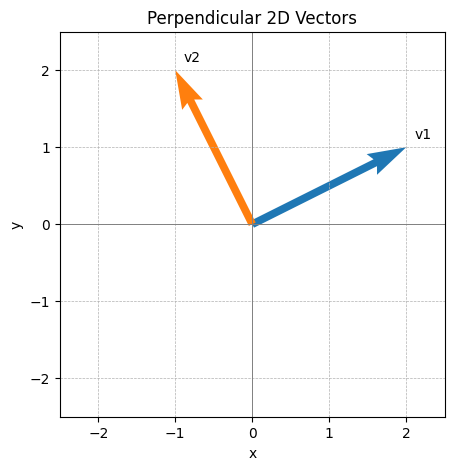

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Example vectors in 2D
v1 = np.array([2.0, 1.0])
# perpendicular vector obtained by rotating v1 by 90 degrees: [-y, x]
v2 = np.array([-v1[1], v1[0]])

fig, ax = plt.subplots(figsize=(5,5))
# draw thin axes lines
ax.axhline(0, color='gray', linewidth=0.7)
ax.axvline(0, color='gray', linewidth=0.7)

# plot vectors using quiver so lengths are respected
ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color='C0', width=0.02)
ax.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color='C1', width=0.02)

# annotate tips
ax.annotate('v1', xy=(v1[0], v1[1]), xytext=(6,6), textcoords='offset points')
ax.annotate('v2', xy=(v2[0], v2[1]), xytext=(6,6), textcoords='offset points')

# determine symmetric plot limits and enforce equal aspect ratio
max_coord = np.max(np.abs(np.vstack((v1, v2)))) * 1.25
ax.set_xlim(-max_coord, max_coord)
ax.set_ylim(-max_coord, max_coord)
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Perpendicular 2D Vectors')
ax.grid(True, linestyle='--', linewidth=0.5)
plt.show()

## Zero Inner Product in 3D

* Similarly, in 3D, $\langle v_1, v_2\rangle = \langle v_1, v_3\rangle = \langle v_2, v_3\rangle = 0$ means the 3 vectors are mutually perpendicular
* This can be shown by first writing the vectors in spherical coordinates
\begin{align*}
\begin{cases}
x = \sin \phi \cos \theta\\
y = \sin \phi \sin \theta\\
z = \cos \phi
\end{cases}, 
\end{align*}
but I'll spare you the details

## Perpendicular in 3D

* Mutually perpendicular 3D vectors with norm 1 are just "rotation" of $(1, 0, 0)^{\mathsf T}$, $(0, 1, 0)^{\mathsf T}$ and $(0, 0, 1)^{\mathsf T}$

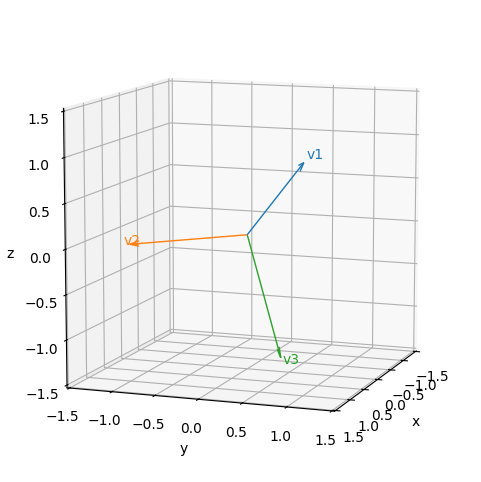

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define three mutually perpendicular vectors in 3D
v1 = np.array([1.0, 1.0, 1.0])
v2 = np.array([1.0, -1.0, 0.0])  # v1.dot(v2) = 0
# v3 is chosen as the cross product v1 x v2 to ensure orthogonality and then scaled
v3 = np.cross(v1, v2)
v3 = v3 / np.linalg.norm(v3) * 1.5

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# plot arrows from origin; arrow_length_ratio controls head size
ax.quiver(0, 0, 0, v1[0], v1[1], v1[2], color='C0', linewidth=1, arrow_length_ratio=0.08)
ax.quiver(0, 0, 0, v2[0], v2[1], v2[2], color='C1', linewidth=1, arrow_length_ratio=0.08)
ax.quiver(0, 0, 0, v3[0], v3[1], v3[2], color='C2', linewidth=1, arrow_length_ratio=0.08)

# annotate tips
ax.text(*(v1 * 1.05), 'v1', color='C0')
ax.text(*(v2 * 1.05), 'v2', color='C1')
ax.text(*(v3 * 1.05), 'v3', color='C2')

# symmetric limits around origin
max_coord = np.max(np.abs(np.vstack((v1, v2, v3)))) * 1.25
ax.set_xlim(-max_coord, max_coord)
ax.set_ylim(-max_coord, max_coord)
ax.set_zlim(-max_coord, max_coord)

# enforce equal aspect ratio if supported
try:
    ax.set_box_aspect([1,1,1])
except Exception:
    # older matplotlib: approximate equal aspect by leaving symmetric limits
    pass

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_title('Three Mutually Perpendicular 3D Vectors')
# Set a camera view (elevation, azimuth) to make perpendicular relationships easier to see
ax.view_init(elev=10, azim=20)
plt.show()

## Zero Inner Product in General ($n$-D)

* In 2D there can be at most 2 vectors that are mutually perpendicular
* In 3D there can be at most 3 vectors that are mutually perpendicular
* In general, in $n$-D there can be at most $n$ vectors that are mutually perpendicular
    * In fact that's the definition of the dimension in linear algebra: Maximum number of vectors one can find in a space that's mutually independent
    * Given a set of mutually independent vectors, mutually perpendicular vectors can be constructed through the Gram-Schmidt process

* An $n\times n$ unitary matrix is one whose $n$ column vectors are mutually perpendicular with norm 1
* Such $n$ vectors are just rotation of the so called standard basis $(1, 0,\ldots, 0)^{\mathsf T}$, $(0, 1,\ldots, 0)^{\mathsf T}$ and $(0, 0,\ldots, 1)^{\mathsf T}$

## Unitary Matrix as a Rotation Matrix

* 2D unit vector has the general form $(\cos\theta, \sin\theta)^{\mathsf T}$
* A 2D unit vector that's perpendicular to $(\cos\theta, \sin\theta)^{\mathsf T}$ must be (?) $(\cos(\theta+\pi/2), \sin(\theta+\pi/2))^{\mathsf T} = (-\sin\theta, \cos\theta)^{\mathsf T}$
    * The direction is unique but sign can change, that is, -$(-\sin\theta, \cos\theta)^{\mathsf T}$ is also a perpendicular vector
* Thus $2\times 2$ unitary matrices have the general form
\begin{align*}
R = 
\begin{pmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta\\
\end{pmatrix},
\end{align*}
which is a rotation matrix
* Rotation matrix $R$ has the property that $R\vec v$ rotates the direction of $\vec v$ counterclockwise through $\theta$
* In general, an $n\times n$ unitary matrix is a rotation matrix that, when multiplied by an $n$-D vector, rotates the vector

## One Property of SVD

* Recall that $X_{m\times n} = USV^{\mathsf T}$ with $m>n$. We will write $T = US$ and $X = TV^{\mathsf T}$: 
\begin{align*}
X_{m\times n} &= \begin{pmatrix}
&\\
|&|&  &&& | \\\\
u_1 & u_2 && \cdots && u_m \\\\
|&|&  &&& | \\\\
\end{pmatrix}_{m\times m}\begin{pmatrix}
s_{1, 1} & 0 & \cdots & 0\\ 
0 & s_{2, 1} & \cdots & 0\\ 
\vdots & \vdots & \ddots & \vdots\\ 
0 & 0 & \cdots & s_{n, n}\\ 
\vdots & \vdots & \vdots & \vdots\\ 
0 & 0 & \cdots & 0\\ 
\end{pmatrix}_{m\times n}\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{} \\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{} \\
& \vdots & \\
\frac{\qquad}{} & v_n^{\mathsf T} & \frac{\qquad}{} \\
\end{pmatrix}_{n\times n}\\
&= TV^{\mathsf T} = \begin{pmatrix}
\\
|&|&  & | \\\\
s_{1, 1} u_1 & s_{2, 2} u_2 & \cdots & s_{n, n}u_n \\\\
|&|&  & | \\\\
\end{pmatrix}_{m\times n}\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{} \\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{} \\
& \vdots & \\
\frac{\qquad}{} & v_n^{\mathsf T} & \frac{\qquad}{} \\
\end{pmatrix}_{n\times n}
\end{align*}

## One Property of SVD (Cont.)

\begin{align*}
X_{m\times n} = TV^{\mathsf T} = \begin{pmatrix}
\\
|&|&  & | \\\\
s_{1, 1} u_1 & s_{2, 2} u_2 & \cdots & s_{n, n}u_n \\\\
|&|&  & | \\\\
\end{pmatrix}_{m\times n}\begin{pmatrix}
\frac{\qquad}{} & v_1^{\mathsf T} & \frac{\qquad}{} \\
\frac{\qquad}{} & v_2^{\mathsf T} & \frac{\qquad}{} \\
& \vdots & \\
\frac{\qquad}{} & v_n^{\mathsf T} & \frac{\qquad}{} \\
\end{pmatrix}_{n\times n}
\end{align*}
* $T$, like $U$, has mutually perpendicular column vectors too but with norms $s_{1, 1}, s_{2, 2}, \ldots s_{n, n}$
    * For example $\langle s_{1, 1}u_1, s_{2, 2}u_2\rangle = s_{1, 1}s_{2, 2}\langle u_1, u_2\rangle = 0$, as $s_{1, 1}$ and $s_{2, 2}$ are just scalars

## Curve PCA

* We start from collecting the yield curve movement data
    * (curve on date $t$) - (curve on date $t-1$)
    * If we use the Treasury yield curve for tenors $\geq$ 1y, it has $n=8$ points
* We collect the daily curve movements from the past 2m (about $m=44$ days)
* The daily curve movement data forms the $m\times n$ matrix $X$, whose SVD gives $X = TV^{\mathsf T}$

* Columns of $V$, denoted by $v_j$, are the principal components (PCs).
    * 1st column $v_1$ is PC1
    * 2nd column $v_2$ is PC2
    * 3rd column $v_3$ is PC3

* Columns of $T$ are PC scores
    * 1st column is scores corresponding to PC1
    * 2nd column is scores corresponding to PC2
    * 3rd column is scores corresponding to PC3

## Data

* Curve data

In [63]:
table('daily-treasury-rates').head(4).iloc[:, 6:]

,1y,2y,3y,5y,7y,10y,20y,30y
10/17/2025,3.56,3.46,3.47,3.59,3.78,4.02,4.58,4.60
10/16/2025,3.54,3.41,3.42,3.55,3.74,3.99,4.56,4.58
10/15/2025,3.61,3.50,3.51,3.63,3.82,4.05,4.61,4.64
10/14/2025,3.58,3.48,3.47,3.60,3.79,4.03,4.59,4.62


* Curve movement

In [67]:
-table('daily-treasury-rates').head(4).iloc[:, 6:].diff()

,1y,2y,3y,5y,7y,10y,20y,30y
10/17/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/16/2025,0.02,0.05,0.05,0.04,0.04,0.03,0.02,0.02
10/15/2025,-0.07,-0.09,-0.09,-0.08,-0.08,-0.06,-0.05,-0.06
10/14/2025,0.03,0.02,0.04,0.03,0.03,0.02,0.02,0.02


## PCs

In [68]:
import numpy

X = -table('daily-treasury-rates').head(67).iloc[:, 6:].diff().dropna().values

m, n = X.shape

u, s, vt = numpy.linalg.svd(X)

T = u[:, :n] * s

v = vt.T

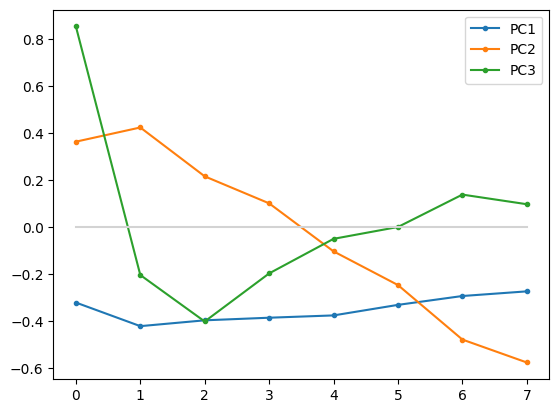

In [91]:
from pandas import DataFrame
import numpy as np

ax = DataFrame(v, columns=[f'PC{j}' for j in range(1, n+1)]).iloc[:, :3].plot(style='.-')
ax.plot(range(8), np.zeros(8), color='lightgray');

## Scores

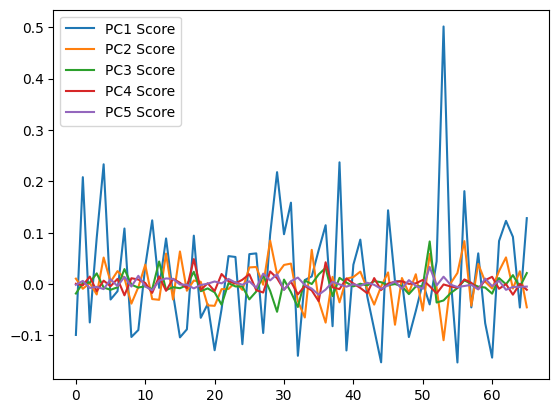

In [75]:
DataFrame(T, columns=[f'PC{j} Score' for j in range(1, n+1)]).iloc[:, :5].plot();